<a href="https://colab.research.google.com/github/mannybernabe/AI_Startup_Prototype/blob/master/Hard_Drive_Failure_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Selecting tensorflow version 2

In [0]:
%tensorflow_version 2.x

#Getting Data and Processing

In [0]:
!wget https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q4_2019.zip
!mkdir extraced_data
!unzip /content/data_Q4_2019.zip -d /content/extraced_data

--2020-04-14 06:34:57--  https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q4_2019.zip
Resolving f001.backblazeb2.com (f001.backblazeb2.com)... 104.153.233.181
Connecting to f001.backblazeb2.com (f001.backblazeb2.com)|104.153.233.181|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 645479954 (616M) [application/zip]
Saving to: ‘data_Q4_2019.zip’

data_Q4_2019.zip    100%[===================>] 615.58M  41.1MB/s    in 17s     

2020-04-14 06:35:14 (37.1 MB/s) - ‘data_Q4_2019.zip’ saved [645479954/645479954]

Archive:  /content/data_Q4_2019.zip
   creating: /content/extraced_data/data_Q4_2019/
  inflating: /content/extraced_data/data_Q4_2019/2019-11-27.csv  
   creating: /content/extraced_data/__MACOSX/
   creating: /content/extraced_data/__MACOSX/data_Q4_2019/
  inflating: /content/extraced_data/__MACOSX/data_Q4_2019/._2019-11-27.csv  
  inflating: /content/extraced_data/data_Q4_2019/2019-11-26.csv  
  inflating: /content/extraced_data/__MACOSX/data_

##Downloaded Data Contains a CSV file for each and every day so joining it to make it a big Dataframe

In [0]:
import os
import numpy as np
import pandas as pd

dfs = []

dateparse = lambda x: pd.to_datetime(x, format='%Y-%m-%d')

for csv in os.listdir("/content/extraced_data/data_Q4_2019"):
  if dfs:
    dfs.append(pd.read_csv(os.path.join("/content/extraced_data/data_Q4_2019", csv), index_col="date", parse_dates=['date'], date_parser=dateparse, dtype=data_types))
  else:
    dfs.append(pd.read_csv(os.path.join("/content/extraced_data/data_Q4_2019", csv), index_col="date", parse_dates=['date'], date_parser=dateparse, dtype={"serial_number": str, "model": str, "capacity_bytes": int, "failure": int}))
    keys = dfs[0].columns
    values = dfs[0].dtypes
    data_types = dict(zip(keys, values))
    del(keys, values)

del([csv, data_types, dateparse])
df = pd.concat(dfs)
del(dfs)
print(len(df))

10991209


In [0]:
df.head()

,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_11_normalized,smart_11_raw,smart_12_normalized,smart_12_raw,smart_13_normalized,smart_13_raw,smart_15_normalized,smart_15_raw,smart_16_normalized,smart_16_raw,smart_17_normalized,smart_17_raw,smart_18_normalized,smart_18_raw,smart_22_normalized,smart_22_raw,smart_23_normalized,smart_23_raw,...,smart_201_normalized,smart_201_raw,smart_218_normalized,smart_218_raw,smart_220_normalized,smart_220_raw,smart_222_normalized,smart_222_raw,smart_223_normalized,smart_223_raw,smart_224_normalized,smart_224_raw,smart_225_normalized,smart_225_raw,smart_226_normalized,smart_226_raw,smart_231_normalized,smart_231_raw,smart_232_normalized,smart_232_raw,smart_233_normalized,smart_233_raw,smart_235_normalized,smart_235_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-21,Z305B2QN,ST4000DM000,4000787030016,0,115.0,86254200.0,NaN,NaN,91.0,0.0,100.0,17.0,100.0,0.0,89.0,848606644.0,NaN,NaN,60.0,35199.0,100.0,0.0,NaN,NaN,100.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,34946.0,100.0,5.189051e+10,100.0,2.052218e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21,ZJV0XJQ4,ST12000NM0007,12000138625024,0,66.0,4016522.0,NaN,NaN,91.0,0.0,100.0,7.0,100.0,0.0,88.0,622964013.0,NaN,NaN,87.0,12226.0,100.0,0.0,NaN,NaN,100.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,11448.0,100.0,5.288988e+10,100.0,1.448682e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21,ZJV0XJQ3,ST12000NM0007,12000138625024,0,83.0,202403808.0,NaN,NaN,99.0,0.0,100.0,1.0,100.0,0.0,81.0,139286349.0,NaN,NaN,90.0,9275.0,100.0,0.0,NaN,NaN,100.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,8914.0,100.0,5.225090e+10,100.0,6.196531e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21,ZJV0XJQ0,ST12000NM0007,12000138625024,0,82.0,155174608.0,NaN,NaN,93.0,0.0,100.0,6.0,100.0,0.0,88.0,625216055.0,NaN,NaN,86.0,12846.0,100.0,0.0,NaN,NaN,100.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,12606.0,100.0,5.536262e+10,100.0,1.125173e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,0,100.0,0.0,134.0,103.0,100.0,436.0,100.0,9.0,100.0,0.0,100.0,0.0,113.0,42.0,97.0,25271.0,100.0,0.0,NaN,NaN,100.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##We want to infer chance of hard drive failure, so let's check the data distribution in our dataset

In [0]:
len(df)

10991209

In [0]:
len(df[(df["failure"]==1)])

678

In [0]:
len(df[(df["failure"]==1)])/len(df)

6.168566169563331e-05

##As Expected the model will not be able to learn this way

([<matplotlib.patches.Wedge at 0x7f2d52d0ad30>,
 [Text(1.0999999793447284, 0.0002131703477807019, 'Failed Instance'),
  Text(-1.0999999793481732, -0.00021315257104041543, 'Healthy Instance')])

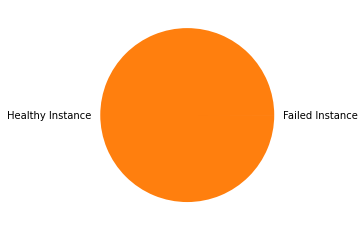

In [0]:
import matplotlib.pyplot as plt
plt.pie([len(df[(df["failure"]==1)]), len(df[(df["failure"]==0)])], labels=["Failed Instance", "Healthy Instance"])

It is practically unseeable in a pie chart, we will have to fix it

##Maybe there are some models of hardrives that have never failed 

In [0]:
models_failed_at_least_once = list(df[(df["failure"]==1)]["model"].value_counts().keys())

In [0]:
len(models_failed_at_least_once)

18

In [0]:
models_never_failed = list(df[(df["failure"]==0)]["model"].value_counts().keys())

In [0]:
len(models_never_failed)

43

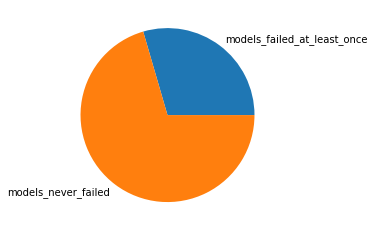

In [0]:
import matplotlib.pyplot as plt
plt.pie([len(models_failed_at_least_once), len(models_never_failed)], labels=["models_failed_at_least_once", "models_never_failed"])
plt.show()

##Looks like the hypothesis was True, now let's see how many instances are there for these unfailed hardrives and remove them as they will be of no use to us practically

In [0]:
len(df[( ~df["model"].isin(models_failed_at_least_once) ) ])

60053

In [0]:
len(df)

10991209

In [0]:
len(df[( ~df["model"].isin(models_failed_at_least_once) ) ])/len(df)

0.005463730150159095

In [0]:
df = df[( df["model"].isin(models_failed_at_least_once) ) ]

In [0]:
len(df[( ~df["model"].isin(models_failed_at_least_once) ) ])

0

In [0]:
df.head()

,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_11_normalized,smart_11_raw,smart_12_normalized,smart_12_raw,smart_13_normalized,smart_13_raw,smart_15_normalized,smart_15_raw,smart_16_normalized,smart_16_raw,smart_17_normalized,smart_17_raw,smart_18_normalized,smart_18_raw,smart_22_normalized,smart_22_raw,smart_23_normalized,smart_23_raw,...,smart_201_normalized,smart_201_raw,smart_218_normalized,smart_218_raw,smart_220_normalized,smart_220_raw,smart_222_normalized,smart_222_raw,smart_223_normalized,smart_223_raw,smart_224_normalized,smart_224_raw,smart_225_normalized,smart_225_raw,smart_226_normalized,smart_226_raw,smart_231_normalized,smart_231_raw,smart_232_normalized,smart_232_raw,smart_233_normalized,smart_233_raw,smart_235_normalized,smart_235_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-21,Z305B2QN,ST4000DM000,4000787030016,0,115.0,86254200.0,NaN,NaN,91.0,0.0,100.0,17.0,100.0,0.0,89.0,848606644.0,NaN,NaN,60.0,35199.0,100.0,0.0,NaN,NaN,100.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,34946.0,100.0,5.189051e+10,100.0,2.052218e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21,ZJV0XJQ4,ST12000NM0007,12000138625024,0,66.0,4016522.0,NaN,NaN,91.0,0.0,100.0,7.0,100.0,0.0,88.0,622964013.0,NaN,NaN,87.0,12226.0,100.0,0.0,NaN,NaN,100.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,11448.0,100.0,5.288988e+10,100.0,1.448682e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21,ZJV0XJQ3,ST12000NM0007,12000138625024,0,83.0,202403808.0,NaN,NaN,99.0,0.0,100.0,1.0,100.0,0.0,81.0,139286349.0,NaN,NaN,90.0,9275.0,100.0,0.0,NaN,NaN,100.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,8914.0,100.0,5.225090e+10,100.0,6.196531e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21,ZJV0XJQ0,ST12000NM0007,12000138625024,0,82.0,155174608.0,NaN,NaN,93.0,0.0,100.0,6.0,100.0,0.0,88.0,625216055.0,NaN,NaN,86.0,12846.0,100.0,0.0,NaN,NaN,100.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,12606.0,100.0,5.536262e+10,100.0,1.125173e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,0,100.0,0.0,134.0,103.0,100.0,436.0,100.0,9.0,100.0,0.0,100.0,0.0,113.0,42.0,97.0,25271.0,100.0,0.0,NaN,NaN,100.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##Let's see the staistical significance of our data

In [0]:
df.describe()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_11_normalized,smart_11_raw,smart_12_normalized,smart_12_raw,smart_13_normalized,smart_13_raw,smart_15_normalized,smart_15_raw,smart_16_normalized,smart_16_raw,smart_17_normalized,smart_17_raw,smart_18_normalized,smart_18_raw,smart_22_normalized,smart_22_raw,smart_23_normalized,smart_23_raw,smart_24_normalized,smart_24_raw,...,smart_201_normalized,smart_201_raw,smart_218_normalized,smart_218_raw,smart_220_normalized,smart_220_raw,smart_222_normalized,smart_222_raw,smart_223_normalized,smart_223_raw,smart_224_normalized,smart_224_raw,smart_225_normalized,smart_225_raw,smart_226_normalized,smart_226_raw,smart_231_normalized,smart_231_raw,smart_232_normalized,smart_232_raw,smart_233_normalized,smart_233_raw,smart_235_normalized,smart_235_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
count,1.093116e+07,1.093116e+07,1.093005e+07,1.093005e+07,3.010175e+06,3.010175e+06,1.093005e+07,1.093005e+07,1.093005e+07,1.093005e+07,1.093005e+07,1.093005e+07,1.093005e+07,1.093005e+07,3.010175e+06,3.010175e+06,1.093005e+07,1.093005e+07,1.093005e+07,1.093005e+07,64289.000000,64289.000000,10930049.0,1.093005e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,321274.0,321274.0,1.231318e+06,1.231318e+06,232122.0,232122.0,232122.0,232122.0,...,0.0,0.0,0.0,0.0,311505.0,3.115050e+05,311505.000000,311505.000000,500127.000000,500127.000000,311505.0,311505.0,45102.000000,4.510200e+04,311505.0,311505.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.217847e+06,8.217847e+06,8044207.0,8.044207e+06,8044207.0,8.044207e+06,0.0,0.0,0.0,0.0,0.0,0.0,23025.0,23025.0,0.0,0.0
mean,8.631112e+12,6.202455e-05,9.164712e+01,8.826103e+07,1.244480e+02,6.719970e+01,9.719915e+01,2.355669e+02,9.999805e+01,9.601388e+00,1.007948e+02,2.248981e+01,9.134188e+01,1.390543e+09,1.140299e+02,2.328792e+01,8.227656e+01,1.956610e+04,1.006200e+02,3.240907e+01,99.566302,741.968471,100.0,6.696721e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,9.999741e+01,9.999898e+01,100.0,0.0,100.0,0.0,...,NaN,NaN,NaN,NaN,100.0,6.266771e+07,79.783092,8286.625242,99.943860,116.080787,100.0,0.0,72.269678,3.238975e+05,100.0,460.072500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.996712e+01,1.951717e+04,100.0,5.335960e+10,100.0,1.403739e+11,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,NaN,NaN
std,3.613872e+12,7.875323e-03,1.491616e+01,8.117062e+07,2.207686e+01,4.809556e+01,1.325949e+01,1.118396e+03,1.230047e-01,1.327973e+02,1.060182e+01,6.364395e+02,1.353186e+01,6.492308e+10,1.989445e+01,1.880353e+01,1.442687e+01,1.142420e+04,9.747132e+00,1.960205e+03,0.944151,1035.239712,0.0,1.122709e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,3.135895e-01,1.347229e-01,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,8.167429e+07,18.874791,7549.281600,0.368786,1245.761793,0.0,0.0,28.853244,4.095566e+05,0.0,144.670432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.272173e+00,1.152519e+04,0.0,1.579870e+10,0.0,1.669267e+11,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
min,-1.000000e+00,0.000000e+00,4.800000e+01,0.000000e+00,8.600000e+01,0.000000e+00,7.000000e+01,0.000000e+00,7.500000e+01,1.000000e+00,2.000000e+00,0.000000e+00,5.300000e+01,0.000000e+00,1.000000e+02,0.000000e+00,2.300000e+01,0.000000e+00,7.500000e+01,0.000000e+00,87.000000,0.000000,100.0,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,4.400000e+01,5.800000e+01,100.0,0.0,100.0,0.0,...,NaN,NaN,NaN,NaN,100.0,0.000000e+00,23.000000,0.000000,87.000000,0.000000,100.0,0.0,1.000000,3.480200e+04,100.0,160.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.300000e+01,0.000000e+00,100.0,0.000000e+00,100.0,2.366000e+0

In [0]:
correlation_matrix = df.corr()

In [0]:
correlation_matrix

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_11_normalized,smart_11_raw,smart_12_normalized,smart_12_raw,smart_13_normalized,smart_13_raw,smart_15_normalized,smart_15_raw,smart_16_normalized,smart_16_raw,smart_17_normalized,smart_17_raw,smart_18_normalized,smart_18_raw,smart_22_normalized,smart_22_raw,smart_23_normalized,smart_23_raw,smart_24_normalized,smart_24_raw,...,smart_201_normalized,smart_201_raw,smart_218_normalized,smart_218_raw,smart_220_normalized,smart_220_raw,smart_222_normalized,smart_222_raw,smart_223_normalized,smart_223_raw,smart_224_normalized,smart_224_raw,smart_225_normalized,smart_225_raw,smart_226_normalized,smart_226_raw,smart_231_normalized,smart_231_raw,smart_232_normalized,smart_232_raw,smart_233_normalized,smart_233_raw,smart_235_normalized,smart_235_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
capacity_bytes,1.000000,0.000564,-0.620181,0.106332,-0.572412,-0.551339,-0.073677,0.118839,0.022923,-0.037164,-0.170417,0.024387,-0.247206,-0.006881,-0.220720,-0.770634,0.457458,-0.829364,-0.143903,-0.020570,NaN,NaN,NaN,-0.125438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001716,0.007313,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.448709,0.737385,-0.737380,0.259216,-0.125696,NaN,NaN,NaN,NaN,NaN,0.982524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065190,-0.800673,NaN,-0.108482,NaN,-0.196450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
failure,0.000564,1.000000,-0.001715,0.002166,0.002393,-0.004037,-0.001694,-0.000118,-0.000916,0.001085,0.000992,0.044478,0.000019,0.000082,0.004152,-0.003596,-0.002223,-0.000171,0.001859,-0.000130,-0.018939,0.016455,NaN,0.001269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000024,0.000022,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.006574,-0.014340,0.014342,-0.013029,0.004117,NaN,NaN,-0.000385,0.000939,NaN,-0.014433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000226,-0.001416,NaN,0.001335,NaN,0.000215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_1_normalized,-0.620181,-0.001715,1.000000,-0.121100,0.005894,-0.093169,0.238630,0.132041,-0.065689,0.082880,0.153547,-0.024527,0.251508,0.007558,0.002191,-0.012670,-0.307093,0.508279,0.035621,0.009259,0.299609,-0.467470,NaN,0.077010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000130,-0.000119,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000428,0.000262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.183680,0.629394,NaN,-0.067802,NaN,0.135649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_1_raw,0.106332,0.002166,-0.121100,1.000000,-0.006251,0.079484,-0.352660,-0.229023,0.008162,-0.008511,-0.082281,0.014440,-0.360099,0.008674,-0.000852,0.006418,-0.385850,0.083641,-0.069165,-0.017978,-0.250624,0.232037,NaN,0.001119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000016,0.000014,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014613,0.004717,NaN,NaN,0.044151,-0.034870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.041504,0.098986,NaN,0.051453,NaN,0.016604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_2_normalized,-0.572412,0.002393,0.005894,-0.006251,1.000000,0.556435,0.106414,-0.221986,NaN,0.183387,0.711974,-0.006143,0.712574,0.000215,0.888065,0.509971,0.200210,0.503497,0.711618,0.012432,NaN,NaN,NaN,0.217045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005660,0.002086,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.454277,0.233537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.048904,NaN,-0.043321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [0]:
correlation_matrix = correlation_matrix[["failure"]].dropna().sort_values("failure", ascending=False)
correlation_matrix

,failure
failure,1.000000
smart_184_raw,0.112239
smart_5_raw,0.044478
smart_197_raw,0.027452
smart_198_raw,0.020901
...,...
smart_222_normalized,-0.014340
smart_226_raw,-0.014433
smart_11_normalized,-0.018939
smart_187_normalized,-0.051913


In [0]:
len(correlation_matrix)

69

## Looks like we have got a lot of uncorrelated columns to the label

In [0]:
dict(correlation_matrix['failure'])

{'capacity_bytes': 0.0005638635348596977,
 'failure': 1.0,
 'smart_10_normalized': 0.0018594658278078726,
 'smart_10_raw': -0.000130029152635967,
 'smart_11_normalized': -0.01893923293932347,
 'smart_11_raw': 0.016455354353463774,
 'smart_12_raw': 0.001269415190675483,
 'smart_183_normalized': -0.0028517051654116114,
 'smart_183_raw': 0.0006039555625674939,
 'smart_184_normalized': -0.1122386444244238,
 'smart_184_raw': 0.11223864442442393,
 'smart_187_normalized': -0.051913127680115974,
 'smart_187_raw': 0.006764811656048569,
 'smart_188_normalized': 7.061184285270584e-06,
 'smart_188_raw': 0.004770965955873527,
 'smart_189_normalized': 0.00015468155425856203,
 'smart_189_raw': -7.883476658961425e-05,
 'smart_190_normalized': 2.2817763525952307e-05,
 'smart_190_raw': -2.2817763525942512e-05,
 'smart_191_normalized': 0.001415218544186945,
 'smart_191_raw': -0.0003375681350076761,
 'smart_192_normalized': 0.0012709915456749073,
 'smart_192_raw': -8.740303284659878e-05,
 'smart_193_norma

In [0]:
for corr_coeff in list(correlation_matrix['failure']):
    if corr_coeff < 0.0006:
      upper_bound = list(correlation_matrix['failure']).index(corr_coeff)
      break
for corr_coeff in list(correlation_matrix['failure'][::-1]):
    if corr_coeff > -0.4:
      lower_bound = list(correlation_matrix['failure']).index(corr_coeff)
      break

In [0]:
lower_bound

68

In [0]:
upper_bound

29

In [0]:
correlation_matrix['failure'][upper_bound:lower_bound]

capacity_bytes          0.000564
smart_199_raw           0.000507
smart_240_normalized    0.000226
smart_242_raw           0.000215
smart_195_raw           0.000162
smart_189_normalized    0.000155
smart_194_raw           0.000126
smart_7_raw             0.000082
smart_199_normalized    0.000068
smart_200_normalized    0.000043
smart_22_normalized     0.000024
smart_190_normalized    0.000023
smart_22_raw            0.000022
smart_7_normalized      0.000019
smart_188_normalized    0.000007
smart_190_raw          -0.000023
smart_189_raw          -0.000079
smart_192_raw          -0.000087
smart_3_raw            -0.000118
smart_10_raw           -0.000130
smart_9_raw            -0.000171
smart_191_raw          -0.000338
smart_225_normalized   -0.000385
smart_193_raw          -0.000520
smart_4_normalized     -0.000916
smart_240_raw          -0.001416
smart_3_normalized     -0.001694
smart_1_normalized     -0.001715
smart_9_normalized     -0.002223
smart_183_normalized   -0.002852
smart_194_

In [0]:
correlation_matrix.index

Index(['failure', 'smart_184_raw', 'smart_5_raw', 'smart_197_raw',
       'smart_198_raw', 'smart_11_raw', 'smart_222_raw', 'smart_196_raw',
       'smart_187_raw', 'smart_196_normalized', 'smart_188_raw',
       'smart_8_normalized', 'smart_223_raw', 'smart_195_normalized',
       'smart_2_normalized', 'smart_200_raw', 'smart_1_raw',
       'smart_10_normalized', 'smart_198_normalized', 'smart_191_normalized',
       'smart_241_raw', 'smart_192_normalized', 'smart_12_raw',
       'smart_193_normalized', 'smart_4_raw', 'smart_197_normalized',
       'smart_5_normalized', 'smart_225_raw', 'smart_183_raw',
       'capacity_bytes', 'smart_199_raw', 'smart_240_normalized',
       'smart_242_raw', 'smart_195_raw', 'smart_189_normalized',
       'smart_194_raw', 'smart_7_raw', 'smart_199_normalized',
       'smart_200_normalized', 'smart_22_normalized', 'smart_190_normalized',
       'smart_22_raw', 'smart_7_normalized', 'smart_188_normalized',
       'smart_190_raw', 'smart_189_raw', 'smart

## Also there are so many null values

In [0]:
total_values = len(df.columns) * len(df)
total_values

1421050280

In [0]:
number_of_null_values = df.isna().sum().sum()
number_of_null_values

899840838

In [0]:
number_of_null_values/total_values

0.6332223783102171

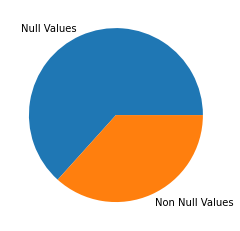

In [0]:
import matplotlib.pyplot as plt
plt.pie([number_of_null_values, (total_values-number_of_null_values)], labels=["Null Values", "Non Null Values"])
plt.show()

## Let's remove these useless columns

In [0]:
def delnullcol(dt):
    nullcol = [col for col in dt.columns if dt[col].isnull().sum()/dt.shape[0] >= 0.8]
    return nullcol

In [0]:
def get_non_correlated_cols(dt):
  correlation_matrix = dt.corr()
  correlation_matrix = correlation_matrix[["failure"]].dropna().sort_values("failure", ascending=False)
  for corr_coeff in list(correlation_matrix['failure']):
      if corr_coeff < 0.0005:
        upper_bound = list(correlation_matrix['failure']).index(corr_coeff)
        break
  for corr_coeff in list(correlation_matrix['failure'][::-1]):
      if corr_coeff > -0.0004:
        lower_bound = list(correlation_matrix['failure']).index(corr_coeff)
        break
  return(list(correlation_matrix['failure'][upper_bound:lower_bound].keys()))

In [0]:
def useless_cols(dt):
    null_cols = delnullcol(dt)
    print("Number of Cols with More than 80% null: " + str(len(null_cols)))
    correlation_matrix = get_non_correlated_cols(dt)
    print("Number of Cols Non Correlated with Hard Drive Failure: " + str(len(correlation_matrix)))
    cols_to_drop = list(set(null_cols + correlation_matrix))
    return(cols_to_drop)

In [0]:
cols_to_drop = useless_cols(df)
print(f"Noumber of cols to drop: {len(cols_to_drop)}")

Number of Cols with More than 80% null: 70
Number of Cols Non Correlated with Hard Drive Failure: 20
Noumber of cols to drop: 88


In [0]:
df.drop(cols_to_drop, axis=1, inplace=True)

In [0]:
df = df.fillna(0)
df = df.replace(np.inf,999)

In [0]:
df.head()

,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_raw,smart_191_normalized,smart_192_normalized,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_195_normalized,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_200_raw,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-21,Z305B2QN,ST4000DM000,4000787030016,0,115.0,86254200.0,0.0,0.0,91.0,100.0,17.0,100.0,0.0,0.0,0.0,60.0,100.0,100.0,17.0,100.0,0.0,100.0,0.0,0.0,100.0,100.0,83.0,34354.0,22.0,0.0,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,34946.0,100.0,5.189051e+10,100.0
2019-12-21,ZJV0XJQ4,ST12000NM0007,12000138625024,0,66.0,4016522.0,0.0,0.0,91.0,100.0,7.0,100.0,0.0,0.0,0.0,87.0,100.0,100.0,7.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,99.0,2532.0,27.0,66.0,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,11448.0,100.0,5.288988e+10,100.0
2019-12-21,ZJV0XJQ3,ST12000NM0007,12000138625024,0,83.0,202403808.0,0.0,0.0,99.0,100.0,1.0,100.0,0.0,0.0,0.0,90.0,100.0,100.0,1.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,100.0,1969.0,32.0,83.0,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,8914.0,100.0,5.225090e+10,100.0
2019-12-21,ZJV0XJQ0,ST12000NM0007,12000138625024,0,82.0,155174608.0,0.0,0.0,93.0,100.0,6.0,100.0,0.0,0.0,0.0,86.0,100.0,100.0,6.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,100.0,1061.0,24.0,82.0,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,12606.0,100.0,5.536262e+10,100.0
2019-12-21,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,0,100.0,0.0,134.0,103.0,100.0,100.0,9.0,100.0,0.0,113.0,42.0,97.0,100.0,100.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,376.0,214.0,0.0,100.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0


In [0]:
df.describe()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_raw,smart_191_normalized,smart_192_normalized,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_195_normalized,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_200_raw,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized
count,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07
mean,8.631112e+12,6.202455e-05,9.163784e+01,8.825209e+07,3.426995e+01,1.850517e+01,9.718931e+01,9.998792e+01,9.600416e+00,1.007846e+02,2.248753e+01,3.140107e+01,6.412929e+00,8.226823e+01,1.006098e+02,9.998987e+01,6.696043e+00,3.828068e+01,3.933710e-06,7.220936e+01,8.035569e-01,1.303795e+08,3.911501e+01,1.004083e+02,9.461143e+01,1.115876e+04,7.485296e+01,3.500508e+01,2.851197e+01,1.854353e-01,1.007889e+02,1.256241e-01,1.006170e+02,1.081985e-01,4.225411e-01,1.245782e+03,1.467266e+04,7.358972e+01,3.926718e+10,7.358972e+01
std,3.613872e+12,7.875323e-03,1.494389e+01,8.117137e+07,5.678567e+01,3.921855e+01,1.329485e+01,1.013750e+00,1.327907e+02,1.064969e+01,6.364073e+02,5.199639e+01,1.433818e+01,1.444988e+01,9.799089e+00,1.006280e+00,1.122673e+01,4.860717e+01,4.734236e-03,4.474006e+01,1.673329e+02,3.620767e+09,4.728800e+01,8.091453e+00,1.380011e+01,2.560512e+04,7.932779e+01,3.949404e+01,4.723541e+01,1.601562e+01,1.061721e+01,9.644815e+00,9.795898e+00,9.434719e+00,3.119328e+01,2.459689e+04,1.307445e+04,4.408543e+01,2.714864e+10,4.408543e+01
min,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000787e+12,0.000000e+00,8.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,9.100000e+01,1.000000e+02,3.000000e+00,1.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.200000e+01,1.000000e+02,1.000000e+02,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02,9.500000e+01,3.910000e+02,2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02,0.000000e+00,1.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.001563e+12,0.000000e+00,8.300000e+01,7.523886e+07,0.000000e+00,0.000000e+00,9.500000e+01,1.000000e+02,6.000000e+00,1.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,8.300000e+01,1.000000e+02,1.000000e+02,5.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02,1.000000e+02,1.075000e+03,3.100000e+01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02,0.000000e+00,1.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.497100e+04,1.000000e+02,5.228187e+10,1.000000e+02
75%,1.200014e+13,0.000000e+00,1.000000e+02,1.601550e+08,1.000000e+02,0.000000e+00,1.000000e+02,1.000000e+02,9.000000e+00,1.000000e+02,0.000000e+00,1.000000e+02,0.000000e+00,9.7

## Let's see the significance of model name in inference

In [0]:
df[["model", "failure"]].groupby(['model']).sum()

,failure
model,
HGST HMS5C4040ALE640,4
HGST HMS5C4040BLE640,12
HGST HUH721212ALE600,1
HGST HUH721212ALN604,7
HGST HUH728080ALE600,2
ST10000NM0086,5
ST12000NM0007,364
ST12000NM0008,10
ST4000DM000,119


## Looks like it does matter

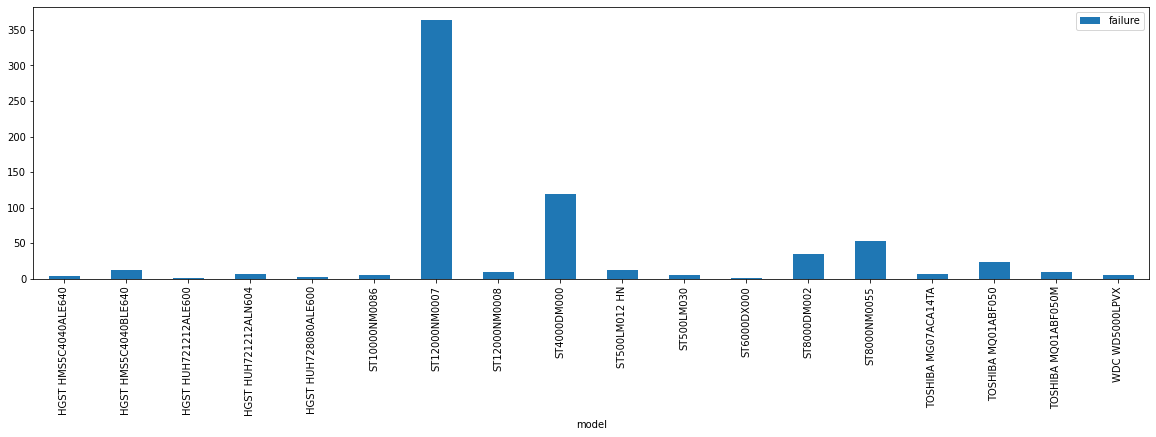

In [0]:
df[["model", "failure"]].groupby(['model']).sum().plot(kind="bar", figsize=(20,5))
plt.show()

##How ever time doesn't seem to be a determining factor here as seen in this diagram that lacks any seasonality or auto correlation so let's not treat this as time series data

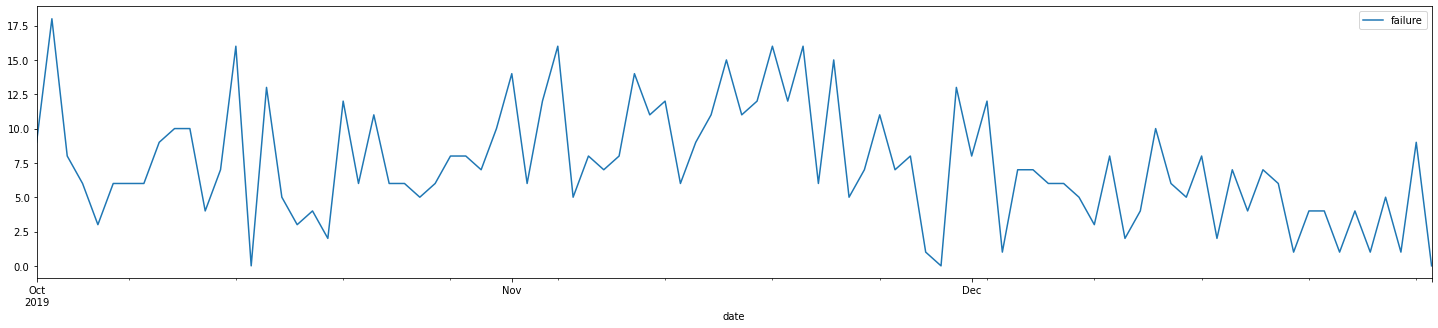

In [0]:
df[["failure"]].groupby(df.index).sum().plot(figsize=(25,5))
plt.show()

##Let's look at this with both model and time in mind

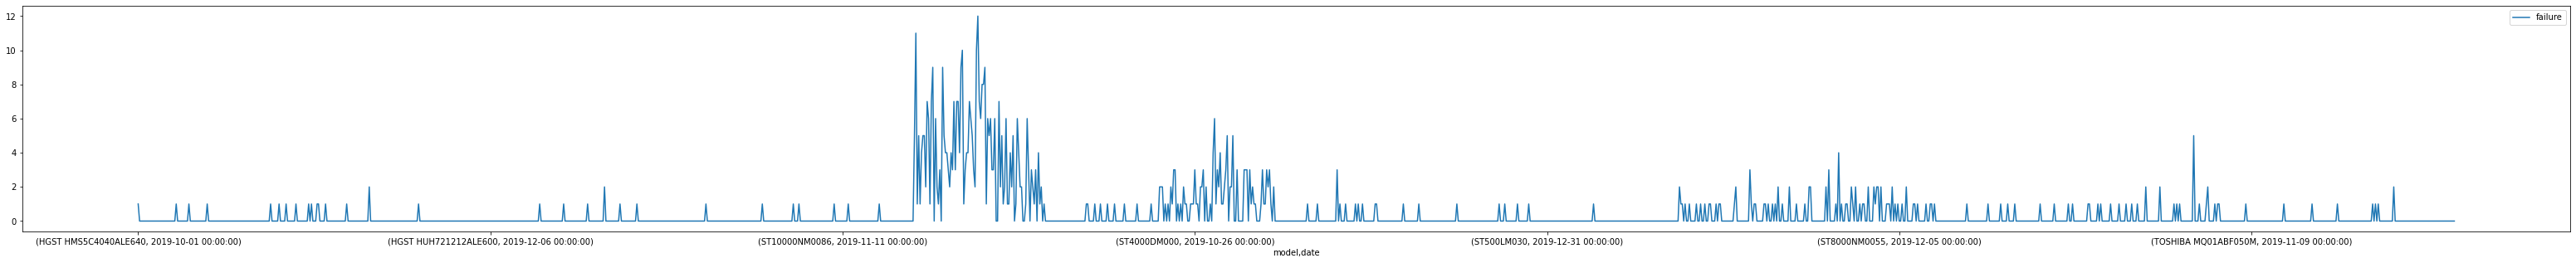

In [0]:
df[["model", "failure"]].groupby(["model", df.index]).sum().plot(figsize=(55,5), legend=True)
plt.show()

##Looks like it is indeed a determining factor which can be further seen in this granular graph

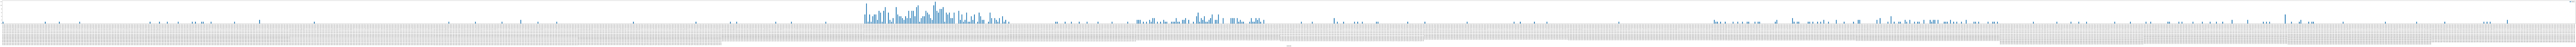

In [0]:
df[["model", "failure"]].groupby(["model", df.index]).sum().plot(kind="bar", figsize=(550,5), legend=True)
plt.show()

##However, serial number as expected has nothing to do with failure so let's drop it.

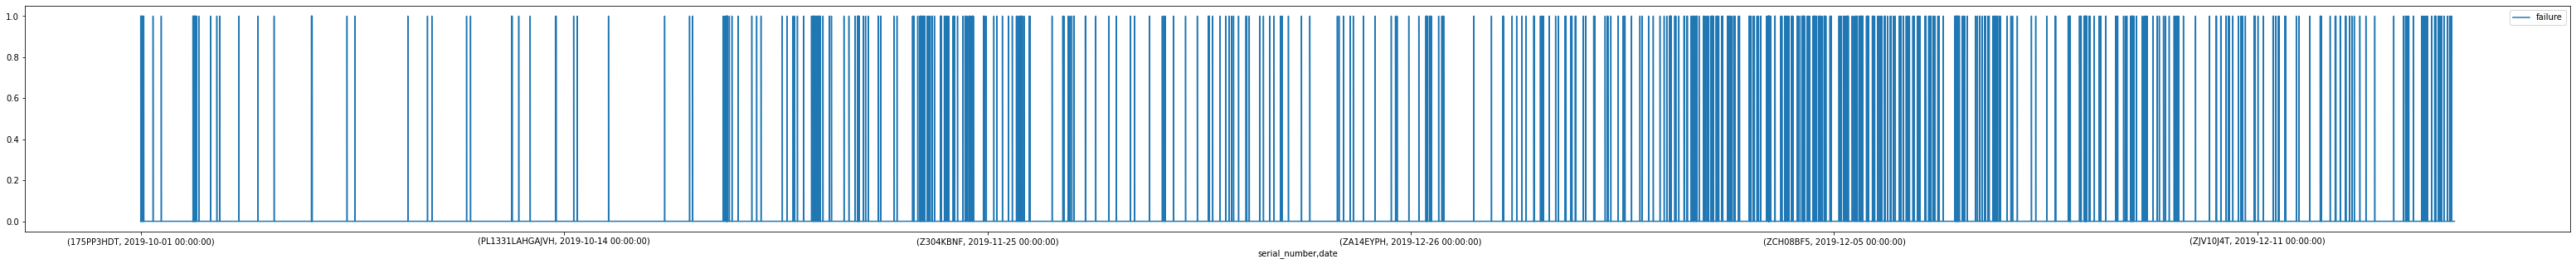

In [0]:
df[["serial_number", "failure"]].groupby(["serial_number", df.index]).sum().plot(figsize=(55,5), legend=True)
plt.show()

In [0]:
df.drop("serial_number", axis=1, inplace=True)

In [0]:
df.head()

,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_raw,smart_191_normalized,smart_192_normalized,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_195_normalized,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_200_raw,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-21,ST4000DM000,4000787030016,0,115.0,86254200.0,0.0,0.0,91.0,100.0,17.0,100.0,0.0,0.0,0.0,60.0,100.0,100.0,17.0,100.0,0.0,100.0,0.0,0.0,100.0,100.0,83.0,34354.0,22.0,0.0,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,34946.0,100.0,5.189051e+10,100.0
2019-12-21,ST12000NM0007,12000138625024,0,66.0,4016522.0,0.0,0.0,91.0,100.0,7.0,100.0,0.0,0.0,0.0,87.0,100.0,100.0,7.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,99.0,2532.0,27.0,66.0,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,11448.0,100.0,5.288988e+10,100.0
2019-12-21,ST12000NM0007,12000138625024,0,83.0,202403808.0,0.0,0.0,99.0,100.0,1.0,100.0,0.0,0.0,0.0,90.0,100.0,100.0,1.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,100.0,1969.0,32.0,83.0,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,8914.0,100.0,5.225090e+10,100.0
2019-12-21,ST12000NM0007,12000138625024,0,82.0,155174608.0,0.0,0.0,93.0,100.0,6.0,100.0,0.0,0.0,0.0,86.0,100.0,100.0,6.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,100.0,1061.0,24.0,82.0,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,12606.0,100.0,5.536262e+10,100.0
2019-12-21,HGST HMS5C4040ALE640,4000787030016,0,100.0,0.0,134.0,103.0,100.0,100.0,9.0,100.0,0.0,113.0,42.0,97.0,100.0,100.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,376.0,214.0,0.0,100.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0


##Looks like capacity has a high correlation with failure

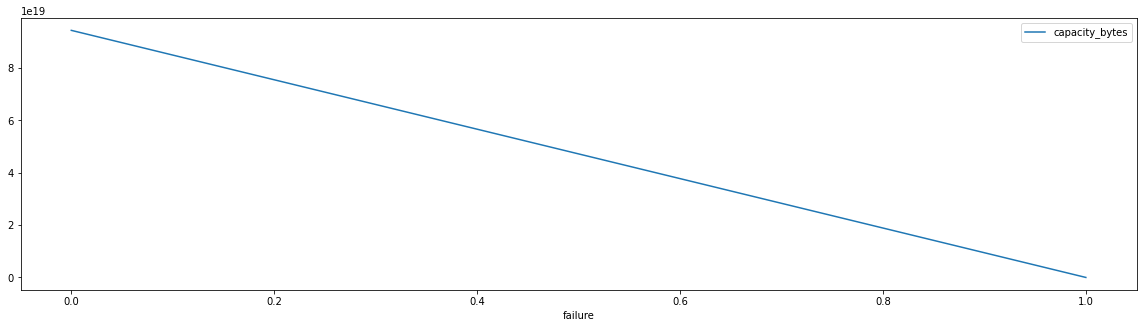

In [0]:
df[["capacity_bytes", "failure"]].groupby(['failure']).sum().plot(figsize=(20,5))
plt.show()

##Now let's dummy the dataset as a ML can't train on string data type

In [0]:
df = pd.get_dummies(df)

In [0]:
df.head()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_raw,smart_191_normalized,smart_192_normalized,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_195_normalized,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_200_raw,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,model_HGST HMS5C4040ALE640,model_HGST HMS5C4040BLE640,model_HGST HUH721212ALE600,model_HGST HUH721212ALN604,model_HGST HUH728080ALE600,model_ST10000NM0086,model_ST12000NM0007,model_ST12000NM0008,model_ST4000DM000,model_ST500LM012 HN,model_ST500LM030,model_ST6000DX000,model_ST8000DM002,model_ST8000NM0055,model_TOSHIBA MG07ACA14TA,model_TOSHIBA MQ01ABF050,model_TOSHIBA MQ01ABF050M,model_WDC WD5000LPVX
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-21,4000787030016,0,115.0,86254200.0,0.0,0.0,91.0,100.0,17.0,100.0,0.0,0.0,0.0,60.0,100.0,100.0,17.0,100.0,0.0,100.0,0.0,0.0,100.0,100.0,83.0,34354.0,22.0,0.0,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,34946.0,100.0,5.189051e+10,100.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2019-12-21,12000138625024,0,66.0,4016522.0,0.0,0.0,91.0,100.0,7.0,100.0,0.0,0.0,0.0,87.0,100.0,100.0,7.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,99.0,2532.0,27.0,66.0,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,11448.0,100.0,5.288988e+10,100.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2019-12-21,12000138625024,0,83.0,202403808.0,0.0,0.0,99.0,100.0,1.0,100.0,0.0,0.0,0.0,90.0,100.0,100.0,1.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,100.0,1969.0,32.0,83.0,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,8914.0,100.0,5.225090e+10,100.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2019-12-21,12000138625024,0,82.0,155174608.0,0.0,0.0,93.0,100.0,6.0,100.0,0.0,0.0,0.0,86.0,100.0,100.0,6.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,100.0,1061.0,24.0,82.0,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,12606.0,100.0,5.536262e+10,100.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2019-12-21,4000787030016,0,100.0,0.0,134.0,103.0,100.0,100.0,9.0,100.0,0.0,113.0,42.0,97.0,100.0,100.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,376.0,214.0,0.0,100.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##Normalize it to make it easier for the model to train on

In [0]:
from sklearn.preprocessing import MinMaxScaler

q = 0
scaler = MinMaxScaler()
for col in df.columns:
    a = np.array(df[col])
    a = a.reshape(-1,1)
    df[col] = scaler.fit_transform(a)
    if q >= 100:
        break
    else:
        q+=1
        continue

In [0]:
df.head()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_raw,smart_191_normalized,smart_192_normalized,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_195_normalized,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_200_raw,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,model_HGST HMS5C4040ALE640,model_HGST HMS5C4040BLE640,model_HGST HUH721212ALE600,model_HGST HUH721212ALN604,model_HGST HUH728080ALE600,model_ST10000NM0086,model_ST12000NM0007,model_ST12000NM0008,model_ST4000DM000,model_ST500LM012 HN,model_ST500LM030,model_ST6000DX000,model_ST8000DM002,model_ST8000NM0055,model_TOSHIBA MG07ACA14TA,model_TOSHIBA MQ01ABF050,model_TOSHIBA MQ01ABF050M,model_WDC WD5000LPVX
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-21,0.285760,0.0,0.575,0.076541,0.000000,0.000000,0.359684,1.0,0.000676,0.396825,0.0,0.000000,0.000000,0.60,0.396825,1.0,0.019563,1.0,0.0,1.0,0.0,0.0,0.396825,0.396825,0.415,0.049399,0.086957,0.000000,0.000000,0.0,0.396825,0.0,0.396825,0.0,0.0,0.0,0.714160,1.0,0.252698,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-21,0.857121,0.0,0.330,0.003564,0.000000,0.000000,0.359684,1.0,0.000278,0.396825,0.0,0.000000,0.000000,0.87,0.396825,1.0,0.008055,0.0,0.0,1.0,0.0,0.0,0.000000,0.396825,0.495,0.003641,0.106719,0.564103,0.000000,0.0,0.396825,0.0,0.396825,0.0,0.0,0.0,0.233953,1.0,0.257565,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-21,0.857121,0.0,0.415,0.179612,0.000000,0.000000,0.391304,1.0,0.000040,0.396825,0.0,0.000000,0.000000,0.90,0.396825,1.0,0.001151,0.0,0.0,1.0,0.0,0.0,0.000000,0.396825,0.500,0.002831,0.126482,0.709402,0.000000,0.0,0.396825,0.0,0.396825,0.0,0.0,0.0,0.182167,1.0,0.254453,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-21,0.857121,0.0,0.410,0.137701,0.000000,0.000000,0.367589,1.0,0.000239,0.396825,0.0,0.000000,0.000000,0.86,0.396825,1.0,0.006904,0.0,0.0,1.0,0.0,0.0,0.000000,0.396825,0.500,0.001526,0.094862,0.700855,0.000000,0.0,0.396825,0.0,0.396825,0.0,0.0,0.0,0.257618,1.0,0.269607,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-21,0.285760,0.0,0.500,0.000000,0.531746,0.097078,0.395257,1.0,0.000358,0.396825,0.0,0.448413,0.933333,0.97,0.396825,1.0,0.010357,0.0,0.0,0.0,0.0,0.0,0.000000,0.396825,0.500,0.000541,0.845850,0.000000,0.396825,0.0,0.396825,0.0,0.396825,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df.describe()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_raw,smart_191_normalized,smart_192_normalized,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_195_normalized,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_200_raw,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,model_HGST HMS5C4040ALE640,model_HGST HMS5C4040BLE640,model_HGST HUH721212ALE600,model_HGST HUH721212ALN604,model_HGST HUH728080ALE600,model_ST10000NM0086,model_ST12000NM0007,model_ST12000NM0008,model_ST4000DM000,model_ST500LM012 HN,model_ST500LM030,model_ST6000DX000,model_ST8000DM002,model_ST8000NM0055,model_TOSHIBA MG07ACA14TA,model_TOSHIBA MQ01ABF050,model_TOSHIBA MQ01ABF050M,model_WDC WD5000LPVX
count,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07,1.093116e+07
mean,6.164852e-01,6.202455e-05,4.581892e-01,7.831436e-02,1.359919e-01,1.744125e-02,3.841475e-01,9.998792e-01,3.818629e-04,3.999387e-01,3.431743e-04,1.246074e-01,1.425095e-01,8.226823e-01,3.992452e-01,9.998987e-01,7.705458e-03,3.828068e-01,4.370789e-07,7.220936e-01,1.226149e-05,2.168273e-04,1.552183e-01,3.984457e-01,4.730571e-01,1.604575e-02,2.958615e-01,2.991887e-01,1.131428e-01,3.533447e-05,3.999560e-01,3.512979e-05,3.992737e-01,3.025686e-05,5.509011e-05,9.001921e-04,2.998520e-01,7.358972e-01,1.912245e-01,7.358972e-01,2.321886e-02,1.069182e-01,1.312944e-02,9.109055e-02,8.422988e-03,9.989794e-03,3.106107e-01,2.939076e-02,1.607884e-01,4.126005e-03,2.106365e-03,7.456759e-03,8.205912e-02,1.204355e-01,2.123929e-02,3.893916e-03,3.368171e-03,1.755258e-03
std,2.581241e-01,7.875323e-03,7.471944e-02,7.203097e-02,2.253399e-01,3.696376e-02,5.254881e-02,1.013750e-02,5.281837e-03,4.226069e-02,9.711991e-03,2.063349e-01,3.186263e-01,1.444988e-01,3.888527e-02,1.006280e-02,1.291913e-02,4.860717e-01,5.260262e-04,4.474006e-01,2.553336e-03,6.021507e-03,1.876508e-01,3.210894e-02,6.900053e-02,3.681891e-02,3.135486e-01,3.375559e-01,1.874421e-01,3.051758e-03,4.213179e-02,2.697096e-03,3.887261e-02,2.638344e-03,4.066920e-03,1.777352e-02,2.671908e-01,4.408543e-01,1.322093e-01,4.408543e-01,1.505980e-01,3.090092e-01,1.138291e-01,2.877378e-01,9.138951e-02,9.944848e-02,4.627437e-01,1.688992e-01,3.673357e-01,6.410133e-02,4.584679e-02,8.602998e-02,2.744548e-01,3.254701e-01,1.441811e-01,6.227964e-02,5.793813e-02,4.185902e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0

##Now let's solve the data distribution problem

In [0]:
len(df[(df["failure"]==1)])

678

In [0]:
len(df[(df["failure"]==0)])

10930478

In [0]:
df = pd.concat([df[(df["failure"]==0)][:int(0.6 * len(df))], df[(df["failure"]==1)]] + [df[(df["failure"]==1)]]*80)

In [0]:
from sklearn.utils import shuffle
df = shuffle(df)

##Still not ideal but any more than this will cause repitition problem

In [0]:
len(df[(df["failure"]==1)])

54918

In [0]:
len(df[(df["failure"]==0)])

6558693

## Let's divide the Dataframe into labels(y) and features(x) and then categories the label to then use categorical_crossentropy as loss

In [0]:
import pickle as pkl
import pandas as pd
df = pkl.load(open("/content/dataframe.pkl", "rb"))
# df.set_index("index")

In [0]:
df.head()

,date,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_raw,smart_191_normalized,smart_192_normalized,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_195_normalized,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_200_raw,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,model_HGST HMS5C4040ALE640,model_HGST HMS5C4040BLE640,model_HGST HUH721212ALE600,model_HGST HUH721212ALN604,model_HGST HUH728080ALE600,model_ST10000NM0086,model_ST12000NM0007,model_ST12000NM0008,model_ST4000DM000,model_ST500LM012 HN,model_ST500LM030,model_ST6000DX000,model_ST8000DM002,model_ST8000NM0055,model_TOSHIBA MG07ACA14TA,model_TOSHIBA MQ01ABF050,model_TOSHIBA MQ01ABF050M,model_WDC WD5000LPVX
0,1573948800000000000,0.571519,0.0,0.400,0.088741,0.000000,0.000000,0.332016,1.0,0.000438,0.396825,0.0,0.000000,0.000000,0.76,0.396825,1.0,0.012658,1.0,0.0,1.0,0.0,0.0,0.380952,0.396825,0.440,0.036048,0.130435,0.008547,0.000000,0.0,0.396825,0.0,0.396825,0.0,0.0,0.0,0.433000,1.0,0.272837,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1573084800000000000,0.857121,0.0,0.410,0.155296,0.000000,0.000000,0.363636,1.0,0.000239,0.396825,0.0,0.000000,0.000000,0.93,0.396825,1.0,0.006904,0.0,0.0,1.0,0.0,0.0,0.000000,0.396825,0.495,0.004182,0.130435,0.700855,0.000000,0.0,0.396825,0.0,0.396825,0.0,0.0,0.0,0.120369,1.0,0.119153,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1573084800000000000,0.571519,0.0,0.500,0.000000,0.000000,0.000000,0.332016,1.0,0.034486,0.396825,0.0,0.000000,0.000000,0.76,0.396825,1.0,0.997699,1.0,0.0,1.0,0.0,0.0,0.384921,0.396825,0.435,0.039394,0.122530,0.854701,0.000000,0.0,0.396825,0.0,0.396825,0.0,0.0,0.0,0.440684,1.0,0.351543,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1571788800000000000,0.285760,0.0,0.500,0.000000,0.527778,0.098021,0.395257,1.0,0.000278,0.396825,0.0,0.448413,0.933333,0.97,0.396825,1.0,0.008055,0.0,0.0,0.0,0.0,0.0,0.000000,0.396825,0.500,0.000634,0.762846,0.000000,0.396825,0.0,0.396825,0.0,0.396825,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1573344000000000000,0.857121,0.0,0.385,0.041752,0.000000,0.000000,0.371542,1.0,0.000159,0.396825,0.0,0.000000,0.000000,0.85,0.396825,1.0,0.004603,0.0,0.0,1.0,0.0,0.0,0.000000,0.396825,0.500,0.000994,0.079051,0.658120,0.000000,0.0,0.396825,0.0,0.396825,0.0,0.0,0.0,0.267447,1.0,0.292492,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
import pickle as pkl

df = df.reset_index()
df["date"] = df["date"].view('int64')
x = df.drop("failure", axis=1)
y = df["failure"]

with open("dataframe.pkl", "wb") as f:
  pkl.dump(df, f)

del(df)

In [0]:
y = pd.get_dummies(y)

In [0]:
x.head()

,date,capacity_bytes,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_raw,smart_191_normalized,smart_192_normalized,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_195_normalized,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_200_raw,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,model_HGST HMS5C4040ALE640,model_HGST HMS5C4040BLE640,model_HGST HUH721212ALE600,model_HGST HUH721212ALN604,model_HGST HUH728080ALE600,model_ST10000NM0086,model_ST12000NM0007,model_ST12000NM0008,model_ST4000DM000,model_ST500LM012 HN,model_ST500LM030,model_ST6000DX000,model_ST8000DM002,model_ST8000NM0055,model_TOSHIBA MG07ACA14TA,model_TOSHIBA MQ01ABF050,model_TOSHIBA MQ01ABF050M,model_WDC WD5000LPVX
0,1573603200000000000,0.285760,0.560,0.039594,0.000000,0.0,0.367589,1.0,0.000278,0.396825,0.0,0.000000,0.0,0.59,0.396825,1.0,0.008055,1.0,0.0,1.0,0.0,0.0,0.396825,0.396825,0.47,0.018255,0.098814,0.000000,0.000000,0.0,0.396825,0.0,0.396825,0.0,0.0,0.0,0.743793,1.0,0.281783,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1573084800000000000,0.857121,0.390,0.057582,0.000000,0.0,0.383399,1.0,0.000119,0.396825,0.0,0.000000,0.0,0.99,0.396825,1.0,0.003452,0.0,0.0,1.0,0.0,0.0,0.000000,0.396825,0.50,0.001483,0.118577,0.666667,0.000000,0.0,0.396825,0.0,0.396825,0.0,0.0,0.0,0.019803,1.0,0.075363,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1574985600000000000,0.857121,0.415,0.162037,0.000000,0.0,0.351779,1.0,0.000557,0.396825,0.0,0.000000,0.0,0.79,0.396825,1.0,0.014960,0.0,0.0,1.0,0.0,0.0,0.000000,0.396825,0.50,0.002711,0.090909,0.709402,0.000000,0.0,0.396825,0.0,0.396825,0.0,0.0,0.0,0.366481,1.0,0.350593,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1576800000000000000,0.285760,0.595,0.204582,0.000000,0.0,0.359684,1.0,0.000636,0.396825,0.0,0.000000,0.0,0.52,0.396825,1.0,0.018412,1.0,0.0,1.0,0.0,0.0,0.396825,0.396825,0.36,0.081256,0.071146,0.000000,0.000000,0.0,0.396825,0.0,0.396825,0.0,0.0,0.0,0.867390,1.0,0.312534,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1570924800000000000,0.857121,0.500,0.000000,0.396825,0.0,0.395257,1.0,0.000080,0.396825,0.0,0.396825,0.0,0.99,0.396825,1.0,0.002301,0.0,0.0,0.0,0.0,0.0,0.000000,0.396825,0.50,0.000659,0.675889,0.000000,0.396825,0.0,0.396825,0.0,0.396825,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##Divide the data into train and test set

In [0]:
x_train = x[:int(0.8*len(x))]
x_test = x[int(0.8*len(x)):]

y_train = y[:int(0.8*len(x))]
y_test = y[int(0.8*len(x)):]
del(x)
del(y)

In [0]:
len(x_train) == len(y_train) and len(x_test) == len(y_test) 

True

([<matplotlib.patches.Wedge at 0x7fa1d485d6d8>,
 [Text(-0.8899184758839805, 0.6465640774744088, 'Training Set'),
  Text(0.8899185061518284, -0.6465640358143178, 'Testing Set')])

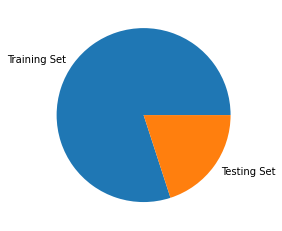

In [0]:
import matplotlib.pyplot as plt
plt.pie([len(y_train), len(y_test)], labels=["Training Set", "Testing Set"])

#Machine Learning

##Deep Learning Approach

###Let's define our model and then train and save it

In [0]:
y_train.sum()

0.0    5247020
1.0      43868
dtype: int64

In [0]:
import tensorflow as tf

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

def weighted_loss(y, y_pred, from_logits=False, label_smoothing=0):
  weights = 100
  loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, labels=y, pos_weight=weights))
  return loss


model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1), input_shape=(x_train.shape[1:])),
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu"),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.LSTM(64, return_sequences=False),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2, activation="softmax"),
  tf.keras.layers.Lambda(lambda x: tf.reshape(x, (-1, 2))),
])


optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True,
    )

model.compile(loss=weighted_loss,
              optimizer=optimizer,
              metrics=["accuracy", weighted_loss])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1, 58)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 64)             18624     
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 128)            66048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [0]:
class_weight = {0: 1.,
                1: 1000.}

In [0]:
history = model.fit(x=x_train, y=y_train, epochs=30, validation_data=(x_test, y_test), batch_size=512, class_weight=class_weight)

In [0]:
model.save("Model.h5")

In [0]:
model.evaluate(x_test, y_test)

41336/41336 [==============================] - 131s 3ms/step - loss: 16.1641 - accuracy: 0.9919 - weighted_loss: 16.1641


[16.164058685302734, 0.9918630123138428, 16.164058685302734]

###Validation accuracy of 99.1% but still deep learning approaches tend to be prone to overfit with this type of data imbalaces even though we are using a weighted loss. In this case a non-deep learning approach might be better so let's try it!

##Non Deep Learning Approach

### Loading Data for Non Deep Learning Approach

In [0]:
import pickle as pkl
import pandas as pd
df = pkl.load(open("/content/dataframe.pkl", "rb"))

In [0]:
x = df.drop("failure", axis=1)
y = df["failure"]
del(df)

In [0]:
x_train = x[:int(0.8*len(x))]
x_test = x[int(0.8*len(x)):]

y_train = y[:int(0.8*len(x))]
y_test = y[int(0.8*len(x)):]

del(x)
del(y)

###Training the model and checking it's accuracy

In [0]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0)
dt.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [0]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(dt, x_test, y_test, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.999, total=  24.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.0s remaining:    0.0s


[CV] .................................... , score=0.999, total=  25.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.5s remaining:    0.0s


[CV] .................................... , score=0.999, total=  26.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min finished


0.9993604103136781

In [0]:
import pickle
with open("decisiontree.pkl", "wb") as f:
  pickle.dump(dt, f)

###Validation accuracy of 99.9%, even better than deep learning model. However, I am skeptical so let's try something



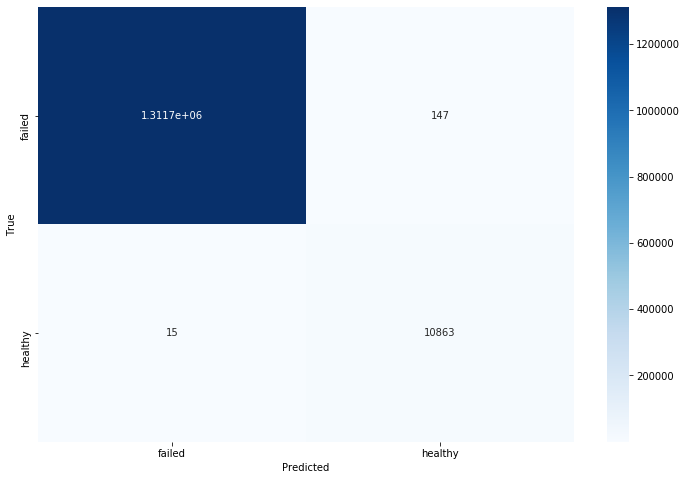

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

classes = ["healthy", "failed"]
y_pred = dt.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(12,8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

###However, looks like only 162 out of millions of prediction were wrong, so statistical model finally wins here!!!